<a href="https://colab.research.google.com/github/KaggleStudy4th/4th_kaggle_study/blob/main/%EC%8B%A4%EC%8A%B5%EC%BD%94%EB%93%9C/7%EC%A3%BC%EC%B0%A8/%EA%B0%80%EC%8A%A4%EA%B3%B5%EA%B8%89%EB%9F%89_%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A1_xgb_kiy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
data=pd.read_csv('/content/drive/MyDrive/dacon/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')

In [12]:
data.head()

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105


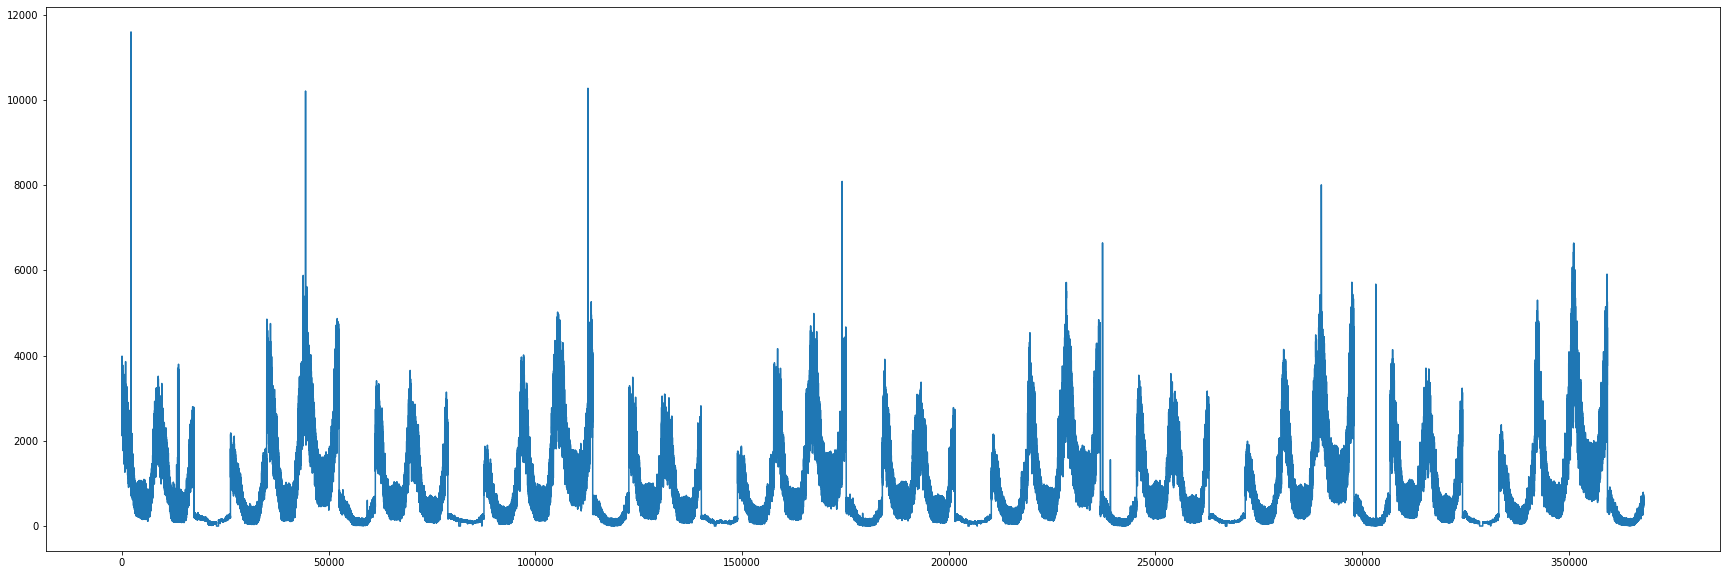

In [13]:
plt.figure(figsize=(30,10))
plt.plot(data['공급량'])   
plt.show() 

# 1. 전처리

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
result = le.fit_transform(data['구분'])
print(result)

[0 0 0 ... 6 6 6]


In [17]:
data['구분']=result
data

,연월일,시간,구분,공급량
0,2013-01-01,1,0,2497.129
1,2013-01-01,2,0,2363.265
2,2013-01-01,3,0,2258.505
3,2013-01-01,4,0,2243.969
4,2013-01-01,5,0,2344.105
...,...,...,...,...
368083,2018-12-31,20,6,681.033
368084,2018-12-31,21,6,669.961
368085,2018-12-31,22,6,657.941
368086,2018-12-31,23,6,610.953


In [14]:
data_unique=np.unique(data['연월일'])
data_unique

array(['2013-01-01', '2013-01-02', '2013-01-03', ..., '2018-12-29',
       '2018-12-30', '2018-12-31'], dtype=object)

In [18]:
data['연월일']=pd.to_datetime(data['연월일'])

In [19]:
data['year']=data['연월일'].dt.year
data['month']=data['연월일'].dt.month
data['day']=data['연월일'].dt.day
data['weekday']=data['연월일'].dt.weekday

In [22]:
data

,연월일,시간,구분,공급량,year,month,day,weekday
0,2013-01-01,1,0,2497.129,2013,1,1,1
1,2013-01-01,2,0,2363.265,2013,1,1,1
2,2013-01-01,3,0,2258.505,2013,1,1,1
3,2013-01-01,4,0,2243.969,2013,1,1,1
4,2013-01-01,5,0,2344.105,2013,1,1,1
...,...,...,...,...,...,...,...,...
368083,2018-12-31,20,6,681.033,2018,12,31,0
368084,2018-12-31,21,6,669.961,2018,12,31,0
368085,2018-12-31,22,6,657.941,2018,12,31,0
368086,2018-12-31,23,6,610.953,2018,12,31,0


In [20]:
train_years = [2013,2014,2015,2016,2017]
val_years = [2018]

In [24]:
train = data[data['year'].isin(train_years)]
val = data[data['year'].isin(val_years)]

In [25]:
features = ['구분', 'month', 'day', 'weekday', '시간']
train_x = data[features]
train_y = data['공급량']

val_x = val[features]
val_y = val['공급량']

# 2. 모델링

파이썬래퍼 XGBoost와 사이킷런래퍼 XGBoost의 가장 큰 차이는
파이썬래퍼는 학습용과 테스트 데이터 세트를 위해 별도의 DMatrix를 생성한다는 점.
DMatrix : 넘파이 입력 파라미터를 받아서 만들어지는 XGBoost만의 전용 데이터 세트

* 주요 입력 파라미터는 data(피처 데이터 세트)와 label
(분류: 레이블 데이터 세트/회귀: 숫자형인 종속값 데이터 세트)
* 판다스의 DataFrame으로 데이터 인터페이스를 하기 위해서는 DataFrame.values를 이용해 넘파이로 일차변환 한 뒤에 DMatrix 변환을 적용

In [29]:
!pip install xgboost

In [31]:
import xgboost as xgb
from xgboost import XGBRegressor 

dtrain = xgb.DMatrix(data=train_x, label = train_y)
dval = xgb.DMatrix(data=val_x, label = val_y)
wlist = [(dtrain, 'train'), (dval,'eval')]

In [32]:
params = {
    'learning_rate': 0.05,
    'objective': 'reg:squarederror',
    'seed':42
}

조기 중단: 수행 성능을 개선하기 위해서 더 이상 지표 개선이 없을 경우에 num_boost_round 횟수를 모두 채우지 않고 중간에 반복을 빠져 나올 수 있도록 함.

* 조기 중단은 xgboost의 train()함수에 early_stopping_rounds파라미터를 입력하여 설정함.

* early_stopping_rounds파라미터를 설정해 조기 중단을 수행하기 위해서는 반드시 eval_set과 eval_metric을 같이 설정해야 함. Xgboost는 반복마다 eval_set으로 지정된 데이터 세트에서 eval_metrics의 지정된 평가 지표로 예측 오류를 측정함.

* eval_set는 성능 평가를 수행할 평가용 이터 세트를 설정.
eval_metric은 평가 세트에 적용할 성능 평가 방법, 분류일 경우 주로 'error'(분류 오류), 'logloss'를 적용.
 
* evals파라미터에 학습 데이터 세트와 eval데이터 세트를 명기해주면 평가를 eval데이터 세트를 수행하면서 조기 중단을 적용할 수 있음. 조기 중단을 수행하려면 반드시 evals파라미터에 eval데이터 세트를 입력할 것.

verbose_eval: (숫자 또는 부울 입력) evals 또한 적어도 하나 개의 원소를 필요로 함. 참이면 evals 소자의 평가 결과가 출력될 것이다 입력 번호가 5라고 가정하면, (5)가 출력 한 번씩 반복됨.

In [33]:
model = xgb.train( params, dtrain, 500, evals=wlist, verbose_eval=20, early_stopping_rounds=100)

[0]	train-rmse:1264.47	eval-rmse:1369.48
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[20]	train-rmse:539.011	eval-rmse:638.062
[40]	train-rmse:321.14	eval-rmse:403.413
[60]	train-rmse:252.784	eval-rmse:318.741
[80]	train-rmse:226.509	eval-rmse:282.026
[100]	train-rmse:213.589	eval-rmse:261.423
[120]	train-rmse:206.317	eval-rmse:249.712
[140]	train-rmse:201.619	eval-rmse:241.603
[160]	train-rmse:198.407	eval-rmse:236.348
[180]	train-rmse:194.696	eval-rmse:230.145
[200]	train-rmse:192.034	eval-rmse:225.601
[220]	train-rmse:190.046	eval-rmse:222.06
[240]	train-rmse:188.075	eval-rmse:218.822
[260]	train-rmse:186.296	eval-rmse:216.227
[280]	train-rmse:184.461	eval-rmse:213.487
[300]	train-rmse:183.051	eval-rmse:211.825
[320]	train-rmse:181.621	eval-rmse:210.052
[340]	train-rmse:178.702	eval-rmse:206.903
[360]	train-rmse:177.218	eval-rmse:205.048
[380]	train-rmse:175.293	eval-rmse:202.492
[400